In [1]:
import numpy as np 


In [26]:
from tensorflow import keras

dataset = keras.utils.image_dataset_from_directory(
    "Dataset",
    label_mode=None,
    image_size=(64,64),
    batch_size=16,
    smart_resize=True,
    shuffle = True
)

Found 4319 files belonging to 1 classes.


In [4]:
for x in dataset:
    print(x)
    break

tf.Tensor(
[[[[2.44000000e+02 2.52000000e+02 2.54000000e+02]
   [2.44000000e+02 2.52000000e+02 2.54000000e+02]
   [2.44000000e+02 2.52000000e+02 2.54000000e+02]
   ...
   [2.41000000e+02 2.51000000e+02 2.53000000e+02]
   [2.41804688e+02 2.51804688e+02 2.53804688e+02]
   [2.41804688e+02 2.51804688e+02 2.53804688e+02]]

  [[2.44000000e+02 2.52000000e+02 2.54000000e+02]
   [2.44000000e+02 2.52000000e+02 2.54000000e+02]
   [2.44000000e+02 2.52000000e+02 2.54000000e+02]
   ...
   [2.41000000e+02 2.51000000e+02 2.53000000e+02]
   [2.41000000e+02 2.51000000e+02 2.53000000e+02]
   [2.41000000e+02 2.51000000e+02 2.53000000e+02]]

  [[2.43195312e+02 2.51195312e+02 2.53195312e+02]
   [2.44000000e+02 2.52000000e+02 2.54000000e+02]
   [2.44000000e+02 2.52000000e+02 2.54000000e+02]
   ...
   [2.41000000e+02 2.51000000e+02 2.53000000e+02]
   [2.42000000e+02 2.52000000e+02 2.54000000e+02]
   [2.43000000e+02 2.51000000e+02 2.54000000e+02]]

  ...

  [[2.18437378e+02 2.42525208e+02 1.62006348e+02]
   [1

In [5]:
dataset = dataset.map(lambda x: (x-127.5)/127.5)


In [20]:
import matplotlib.pyplot as plt
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 127.5 +127.5).astype("int32")[0])
    #print(x)
    break


NotFoundError: NewRandomAccessFile failed to Create/Open: Dataset\archive\00000684.jpg : The system cannot find the path specified.
; No such process
	 [[{{node ReadFile}}]] [Op:IteratorGetNext]

In [12]:
from tensorflow.keras import layers
discriminator = keras.Sequential(
[
keras.Input(shape=(64, 64, 3)),
layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
layers.LeakyReLU(alpha=0.2),
layers.BatchNormalization(),
layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
layers.LeakyReLU(alpha=0.2),
layers.BatchNormalization(),
layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
layers.LeakyReLU(alpha=0.2),
layers.BatchNormalization(),
layers.Flatten(),
layers.Dropout(0.3),
layers.Dense(1, activation="sigmoid"),
],
name="discriminator",
)

In [13]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 batch_normalization_3 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 batch_normalization_4 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                     

In [14]:
latent_dim = 128
generator = keras.Sequential(
[
keras.Input(shape=(latent_dim,)),
layers.Dense(8 * 8 * 128),
layers.Reshape((8, 8, 128)),
layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
layers.ReLU(),
layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
layers.ReLU(),
layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
layers.ReLU(),
layers.Conv2D(3, kernel_size=5, padding="same", activation="tanh"),
],
name="generator",
)

In [15]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 re_lu (ReLU)                (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 re_lu_1 (ReLU)              (None, 32, 32, 256)       0 

In [16]:
import tensorflow as tf
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))],
            axis=0
        )
        labels += 0.1 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))

        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(
                self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(),
                "g_loss": self.g_loss_metric.result()}

In [17]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 127.5
        generated_images += 127.5
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save(f"Generated Images\generated_img_{epoch:03d}_{i}.png")

In [19]:
import datetime
epochs = 200
gan = GAN(discriminator=discriminator, generator=generator,
latent_dim=latent_dim)
gan.compile(
d_optimizer=keras.optimizers.Adam(learning_rate=0.00002,beta_1=0.5),
g_optimizer=keras.optimizers.Adam(learning_rate=0.00002,beta_1=0.5),
loss_fn=keras.losses.BinaryCrossentropy(),
)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

gan.fit(
dataset, epochs=epochs,
callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim), tensorboard_callback]
)

Epoch 1/200
270/270 [==============================] - 10s 33ms/step - d_loss: 0.4736 - g_loss: 0.8520
Epoch 2/200
270/270 [==============================] - 9s 32ms/step - d_loss: 0.3172 - g_loss: 1.7661
Epoch 3/200
270/270 [==============================] - 9s 32ms/step - d_loss: 0.2365 - g_loss: 2.4637
Epoch 4/200
270/270 [==============================] - 9s 31ms/step - d_loss: 0.2263 - g_loss: 2.8081
Epoch 5/200
270/270 [==============================] - 9s 32ms/step - d_loss: 0.3485 - g_loss: 2.1677
Epoch 6/200
270/270 [==============================] - 9s 32ms/step - d_loss: 0.5804 - g_loss: 1.5624
Epoch 7/200
270/270 [==============================] - 9s 33ms/step - d_loss: 0.5526 - g_loss: 1.3646
Epoch 8/200
270/270 [==============================] - 9s 34ms/step - d_loss: 0.5744 - g_loss: 1.1320
Epoch 9/200
270/270 [==============================] - 9s 33ms/step - d_loss: 0.5850 - g_loss: 1.0538
Epoch 10/200
270/270 [==============================] - 9s 32ms/step - d_loss: 0.

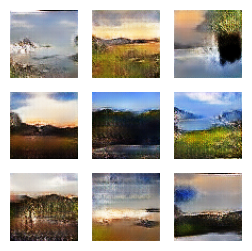

In [107]:
num = 9
random_vector = tf.random.normal(shape=(num, 128))
images = generator(random_vector)
images *= 127.5 
images += 127.5
#print(images)
#print(tf.shape(images[0]))

fig = plt.figure(figsize=(3,3))

for x in range(num):
    plt.subplot(3, 3, x+1)
    img = keras.utils.array_to_img(images[x])
    plt.axis("off")
    plt.imshow(img)